<a href="https://colab.research.google.com/github/PriyanshuRao-code/AI-Lab-Project/blob/main/Random_Forest_Best_Model_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Don't do anything here. It's just a setup.
import os
import sys

repo_name = "AI-Lab-Project"
repo_url = "https://github.com/PriyanshuRao-code/AI-Lab-Project.git"
repo_path = f"/content/{repo_name}"

if os.path.exists(repo_path):
    print("Repository already exists at:", repo_path)
else:
    print("🚀 Cloning the repository...")
    os.system(f"git clone {repo_url}")

os.chdir(repo_path)
sys.path.append(repo_path)

print("Repository is ready to use at:", repo_path)

🚀 Cloning the repository...
Repository is ready to use at: /content/AI-Lab-Project


In [2]:
!pip install import-ipynb
import import_ipynb
from team_24_data_preprocessing import *
from team_24_supervised_learning import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.2 MB/s eta 0:00:00
Repository already exists at: /content/AI-Lab-Project
Repository is ready to use at: /content/AI-Lab-Project
Repository already exists at: /content/AI-Lab-Project
Repository is ready to use at: /content/AI-Lab-Project


In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter


from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import train_test_split

In [4]:
import os
from datetime import datetime

def save_plot(filename, folder="plots", dpi=300):
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    path = os.path.join(folder, f"{filename}_{timestamp}.png")
    plt.savefig(path, dpi=dpi, bbox_inches='tight')
    print(f"Saved: {path}")


In [5]:
df = pd.read_csv("24.csv")

In [6]:
def select_high_corr_features(df_train, df_valid, df_test, target_col="Hazardous", top_n=3):
    df_train_temp = df_train.copy()
    df_train_temp[target_col] = df_train_temp[target_col].astype(int)

    df_train_numeric = df_train_temp.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])

    corr_values = df_train_numeric.corr()[target_col].abs().sort_values(ascending=False)

    selected_features = corr_values.drop(index=target_col).head(top_n).index.tolist()

    return df_train[selected_features + [target_col]], df_valid[selected_features + [target_col]], df_test[selected_features + [target_col]]

In [ ]:

def x_y_separation(df_train, df_valid, df_test, target_column="Hazardous"):
  X_train = df_train.drop(columns=[target_column])
  y_train = df_train[target_column]

  X_valid = df_valid.drop(columns=[target_column])
  y_valid = df_valid[target_column]

  X_test = df_test.drop(columns=[target_column])
  y_test = df_test[target_column]

  return X_train, y_train, X_valid, y_valid, X_test, y_test

In [ ]:
def remove_outliers_zscore(df_train, df_valid, df_test, z_score_threshold = 3):

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_train_non_numeric = df_train.select_dtypes(exclude=['number'])

  z_scores = df_train_numeric.apply(zscore)
  df_z = df_train_numeric[(z_scores.abs() < z_score_threshold).all(axis=1)]  # Remove rows with Z-score >  z_score_threshold in any column
  df_train_cleaned = pd.concat([df_z, df_train_non_numeric.loc[df_z.index]], axis=1)

  return df_train_cleaned, df_valid, df_test


In [7]:
def label_encode_categorical(df_train, df_valid, df_test):

  categorical_cols = df_train.select_dtypes(include=['object']).columns
  label_encoders = {}

  for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df_train[col] = label_encoders[col].fit_transform(df_train[col])

    most_frequent_value = df_train[col].mode()[0]
    df_valid[col] = df_valid[col].map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else most_frequent_value)
    df_test[col] = df_test[col].map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else most_frequent_value)

  df_valid = df_valid[df_train.columns]
  df_test = df_test[df_train.columns]

  return df_train, df_valid, df_test

In [8]:
def standardize_data(df_train_orig, df_valid_orig, df_test_orig):
  df_train = df_train_orig.copy()
  df_valid = df_valid_orig.copy()
  df_test = df_test_orig.copy()
  scaler = StandardScaler()

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_test_numeric = df_test.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_valid_numeric = df_valid.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])

  df_train[df_train_numeric.columns] = scaler.fit_transform(df_train_numeric)
  df_test[df_test_numeric.columns] = scaler.transform(df_test_numeric)
  df_valid[df_valid_numeric.columns] = scaler.transform(df_valid_numeric)

  return df_train, df_valid, df_test

In [10]:
def normalize_date_features(df, month_cols, year_cols):
  for col in month_cols:
    if col in df.columns:
      df[col] = (df[col] - 1) / (12 - 1)

  for col in year_cols:
    if col in df.columns:
      df[col] = (df[col] - 1900) / (2100 - 1900)

  return df

In [9]:
def numeric_conversion(df_orig):
  df = df_orig.copy()

  df.drop(columns=['Equinox', 'Orbiting Body'], errors='ignore', inplace=True)

  df['Close Approach Date'] = pd.to_datetime(df['Close Approach Date'])
  df['Close Approach Year'] = df['Close Approach Date'].dt.year
  df['Close Approach Month'] = df['Close Approach Date'].dt.month

  df['Orbit Determination Date'] = pd.to_datetime(df['Orbit Determination Date'])
  df['Orbit Determination Year'] = df['Orbit Determination Date'].dt.year
  df['Orbit Determination Month'] = df['Orbit Determination Date'].dt.month

  df['Hazardous'] = df['Hazardous'].astype(int)

  df = df.drop(columns=["Close Approach Date", "Orbit Determination Date"])
  return df

In [11]:
def feature_extraction(df_train, df_valid, df_test):
  df_train = numeric_conversion(df_train)
  df_valid = numeric_conversion(df_valid)
  df_test = numeric_conversion(df_test)

  month_cols = ['Close Approach Month', 'Orbit Determination Month']
  year_cols = ['Close Approach Year', 'Orbit Determination Year']

  df_train = normalize_date_features(df_train, month_cols, year_cols)
  df_valid = normalize_date_features(df_valid, month_cols, year_cols)
  df_test = normalize_date_features(df_test, month_cols, year_cols)

  return df_train, df_valid, df_test

In [12]:
def remove_highly_correlated(df_train, df_valid, df_test, high_corr_threshold = 0.99):

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])

  high_corr_pairs = set()
  correlation_matrix = df_train_numeric.corr()

  for i in range(len(correlation_matrix.columns)):
    for j in range(i):
      if abs(correlation_matrix.iloc[i, j]) >= high_corr_threshold:
        col1 = correlation_matrix.columns[i]
        col2 = correlation_matrix.columns[j]
        high_corr_pairs.add((col1, col2))

  columns_to_drop = {col2 for col1, col2 in high_corr_pairs}

  df_train_reduced = df_train.drop(columns=columns_to_drop)
  df_valid_reduced = df_valid.drop(columns=columns_to_drop)
  df_test_reduced = df_test.drop(columns=columns_to_drop)

  return df_train_reduced, df_valid_reduced, df_test_reduced

In [15]:
def remove_outliers_iqr(df_train, df_valid, df_test):

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_train_non_numeric = df_train.select_dtypes(exclude=['number'])

  Q1 = df_train_numeric.quantile(0.25)
  Q3 = df_train_numeric.quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  df_iqr = df_train_numeric[~((df_train_numeric < lower_bound) | (df_train_numeric > upper_bound)).any(axis=1)]
  df_train_cleaned = pd.concat([df_iqr, df_train_non_numeric.loc[df_iqr.index]], axis=1)

  return df_train_cleaned, df_valid, df_test


In [16]:
def perform_pca(df_train, df_valid, df_test, target_col="Hazardous", n_components=11):

  X_train = df_train.drop(columns=[target_col])
  X_valid = df_valid.drop(columns=[target_col])
  X_test  = df_test.drop(columns=[target_col])

  y_train = df_train[target_col].reset_index(drop=True)
  y_valid = df_valid[target_col].reset_index(drop=True)
  y_test  = df_test[target_col].reset_index(drop=True)

  pca = PCA(n_components=n_components)
  pca.fit(X_train)

  X_train_pca = pd.DataFrame(pca.transform(X_train), columns=[f'PC{i+1}' for i in range(n_components)])
  X_valid_pca = pd.DataFrame(pca.transform(X_valid), columns=[f'PC{i+1}' for i in range(n_components)])
  X_test_pca  = pd.DataFrame(pca.transform(X_test),  columns=[f'PC{i+1}' for i in range(n_components)])

  df_train_pca = pd.concat([X_train_pca, y_train], axis=1)
  df_valid_pca = pd.concat([X_valid_pca, y_valid], axis=1)
  df_test_pca  = pd.concat([X_test_pca,  y_test],  axis=1)

  return df_train_pca, df_valid_pca, df_test_pca

In [17]:
def normalize_minmax(df_train_orig, df_valid_orig, df_test_orig):
  df_train = df_train_orig.copy()
  df_valid = df_valid_orig.copy()
  df_test = df_test_orig.copy()
  scaler = MinMaxScaler()

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_test_numeric = df_test.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_valid_numeric = df_valid.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])

  df_train[df_train_numeric.columns] = scaler.fit_transform(df_train_numeric)
  df_test[df_test_numeric.columns] = scaler.transform(df_test_numeric)
  df_valid[df_valid_numeric.columns] = scaler.transform(df_valid_numeric)

  return df_train, df_valid, df_test

In [18]:
def data_random_forest(df):
  df_train, df_temp = train_test_split(df, test_size=0.4, random_state=42)
  df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)
  df_train.reset_index(drop=True, inplace=True)
  df_valid.reset_index(drop=True, inplace=True)
  df_test.reset_index(drop=True, inplace=True)

  df_train, df_valid, df_test = remove_outliers_iqr(df_train, df_valid, df_test)
  df_train, df_valid, df_test = label_encode_categorical(df_train, df_valid, df_test)
  df_train, df_valid, df_test = normalize_minmax(df_train, df_valid, df_test)
  df_train, df_valid, df_test = remove_highly_correlated(df_train, df_valid, df_test)

  return df_train, df_valid, df_test

In [19]:
df_train, df_valid, df_test = data_random_forest(df)

In [20]:
def train_model_random_forest(df_train, df_valid, df_test, target_column="Hazardous", n_estimators=100, random_state=42):

    X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

    X_train_rf = np.array(X_train)
    X_valid_rf = np.array(X_valid)
    X_test_rf = np.array(X_test)

    y_train_rf = np.array(y_train)
    y_valid_rf = np.array(y_valid)
    y_test_rf = np.array(y_test)

    random_forest = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    random_forest.fit(X_train_rf, y_train_rf)

    y_valid_pred_rf = random_forest.predict(X_valid_rf)
    y_test_pred_rf = random_forest.predict(X_test_rf)

    return random_forest, y_valid_rf, y_test_rf, y_valid_pred_rf, y_test_pred_rf,X_test

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(y_true, y_pred, model_name="Model", save=False, filename="conf_matrix.png"):
    print(f"\nEvaluation Metrics for {model_name}:")

    labels = np.unique(np.concatenate((y_true, y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")

    if save:
        plt.savefig(filename)

    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0, average='weighted')
    recall = recall_score(y_true, y_pred, zero_division=0, average='weighted')
    f1 = f1_score(y_true, y_pred, zero_division=0, average='weighted')

    print(f"\n  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")

    return accuracy, precision, recall, f1



Evaluation Metrics for Random Forest Best Model (Validation):


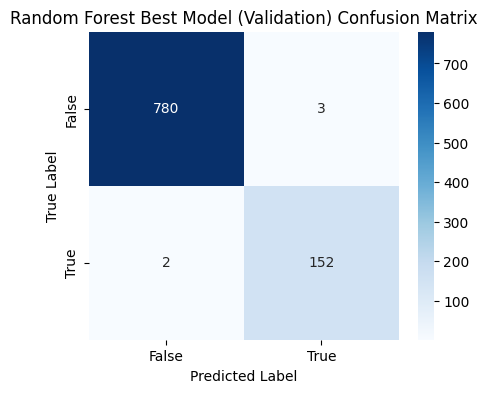


  Accuracy:  0.9947
  Precision: 0.9947
  Recall:    0.9947
  F1-score:  0.9947

Evaluation Metrics for Random Forest Best Model (Test):


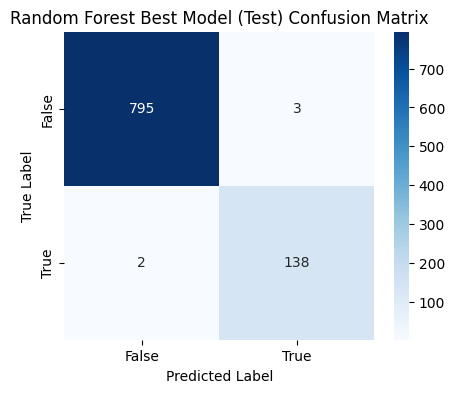


  Accuracy:  0.9947
  Precision: 0.9947
  Recall:    0.9947
  F1-score:  0.9947


(0.9946695095948828,
 0.9946895172552837,
 0.9946695095948828,
 0.9946773234531279)

In [22]:
random_forest, y_valid_rf, y_test_rf, y_valid_pred_rf, y_test_pred_rf,X_test = train_model_random_forest(df_train, df_valid, df_test, target_column="Hazardous", n_estimators=100, random_state=42)
evaluate_model(
    y_valid_rf,
    y_valid_pred_rf,
    model_name="Random Forest Best Model (Validation)",
    save=True,
    filename="rbf_validation_confusion.png"
)

evaluate_model(
    y_test_rf,
    y_test_pred_rf,
    model_name="Random Forest Best Model (Test)",
    save=True,
    filename="rbf_test_confusion.png"
)


In [23]:
def plot_distributions(df, target_column="Hazardous", features_to_plot=None, save=False):
    if features_to_plot is None:
        features_to_plot = df.drop(columns=[target_column]).select_dtypes(include=np.number).columns[:4]

    for feature in features_to_plot:
        plt.figure(figsize=(10, 4))
        sns.histplot(data=df, x=feature, hue=target_column, kde=True, element="step", stat="density", common_norm=False)
        plt.title(f"Distribution of {feature} by Hazardous Classification")
        plt.xlabel(feature)
        plt.ylabel("Density")
        plt.legend(title=target_column, labels=["Not Hazardous", "Hazardous"])
        plt.tight_layout()
        if save:
            save_plot(f"distplot_{feature}")
        plt.show()

        for other_feature in features_to_plot:
            if feature != other_feature:
                plt.figure(figsize=(6, 4))
                sns.scatterplot(data=df, x=feature, y=other_feature, hue=target_column, palette='Set2', alpha=0.7)
                plt.title(f"{feature} vs {other_feature}")
                plt.tight_layout()
                if save:
                    save_plot(f"scatter_{feature}_vs_{other_feature}")
                plt.show()


In [24]:
def plot_correlation_heatmap(df, title="Correlation Heatmap", save=False, filename=None):
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title(title)
    plt.tight_layout()
    if save:
        filename = filename or "correlation_heatmap"
        save_plot(filename)
    plt.show()


In [25]:
def plot_actual_vs_predicted_bar(y_true, y_pred, title="Actual vs Predicted Counts", save=False, filename=None):
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})
    counts = pd.DataFrame({
        'Actual': df['Actual'].value_counts().sort_index(),
        'Predicted': df['Predicted'].value_counts().sort_index()
    })
    counts.plot(kind='bar', figsize=(6, 4), colormap='tab10')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(ticks=[0,1], labels=["Not Hazardous", "Hazardous"], rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    if save:
        filename = filename or "barplot_actual_vs_predicted"
        save_plot(filename)
    plt.show()

In [26]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_pr_curves(model, X_test, y_test, model_name="Model", save=False):
    y_score = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.title(f"{model_name} - ROC Curve", fontsize=14)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    if save:
        save_plot(f"roc_curve_{model_name.replace(' ', '_')}")
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color="green", lw=2)
    plt.title(f"{model_name} - Precision-Recall Curve", fontsize=14)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    if save:
        save_plot(f"precision_recall_curve_{model_name.replace(' ', '_')}")
    plt.show()


In [27]:
def plot_metrics_line(metrics_dict, model_name="Model", save=False):
    metrics_df = pd.DataFrame(metrics_dict, index=[0])
    metrics_df = metrics_df.melt(var_name='Metric', value_name='Score')

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=metrics_df, x='Metric', y='Score', marker='o', sort=False, linewidth=2, color='blue')
    plt.title(f"{model_name} - Evaluation Metrics", fontsize=14)
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    if save:
        save_plot(f"metrics_lineplot_{model_name.replace(' ', '_')}")
    plt.show()


In [28]:
def plot_actual_vs_predicted_line(y_true, y_pred, title="Actual vs Predicted", save=False, filename=None):
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="Actual", marker='o', linestyle='-', alpha=0.7)
    plt.plot(y_pred, label="Predicted", marker='x', linestyle='--', alpha=0.7)
    plt.title(title)
    plt.xlabel("Instance Index")
    plt.ylabel("Label")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    if save:
        filename = filename or "lineplot_actual_vs_predicted"
        save_plot(filename)
    plt.show()


In [29]:
def generate_all_plots(model, X_test, y_test, y_valid, y_pred_valid, y_test_pred, df_train, model_name="Random Forest Best Model", features_to_plot=None):
    plot_distributions(df_train, features_to_plot=features_to_plot, save=True)

    plot_correlation_heatmap(df_train, title="Correlation Heatmap", save=True)

    plot_actual_vs_predicted_bar(y_valid, y_pred_valid, title="Actual vs Predicted - Validation", save=True)
    plot_actual_vs_predicted_bar(y_test, y_test_pred, title="Actual vs Predicted - Test", save=True)

    plot_actual_vs_predicted_line(y_valid, y_pred_valid, title="Line Plot - Validation Set", save=True)
    plot_actual_vs_predicted_line(y_test, y_test_pred, title="Line Plot - Test Set", save=True)

    # plot_roc_pr_curves(model, np.array(X_test), y_test, model_name=model_name, save=True)

    val_metrics = dict(zip(["Accuracy", "Precision", "Recall", "F1"],
                           evaluate_model(y_valid, y_pred_valid, f"{model_name} Validation")))
    plot_metrics_line(val_metrics, model_name=f"{model_name} (Validation)", save=True)

    print("All plots saved successfully.\n")


In [31]:
import os
import glob

def delete_old_plots(folder="plots", extension="png"):
    pattern = os.path.join(folder, f"*.{extension}")
    files = glob.glob(pattern)
    for file in files:
        os.remove(file)
    if not files:
        print("No old plots found to delete.")

delete_old_plots()


No old plots found to delete.


Saved: plots/distplot_Name_20250415_154802.png


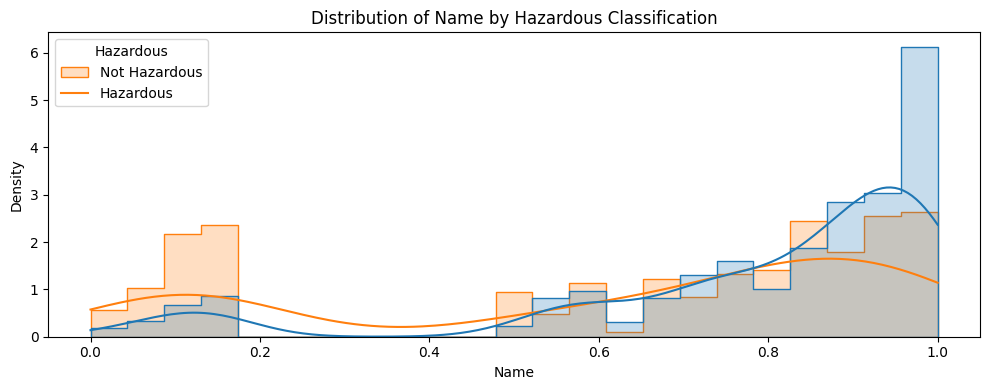

Saved: plots/scatter_Name_vs_Absolute Magnitude_20250415_154803.png


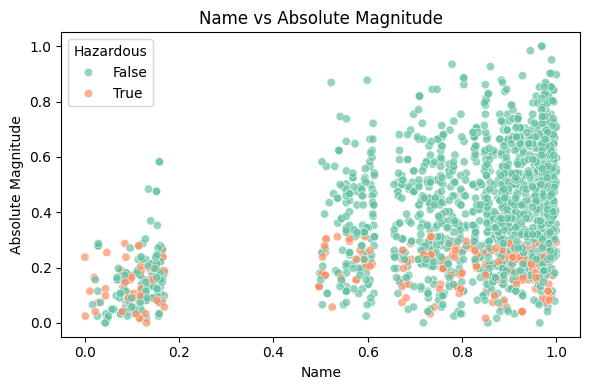

Saved: plots/scatter_Name_vs_Est Dia in Feet(max)_20250415_154803.png


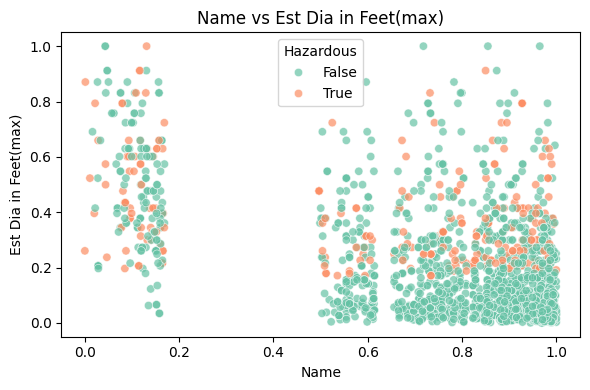

Saved: plots/scatter_Name_vs_Miles per hour_20250415_154804.png


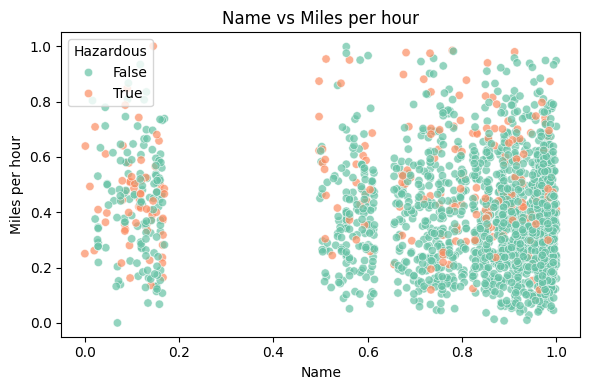

Saved: plots/distplot_Absolute Magnitude_20250415_154805.png


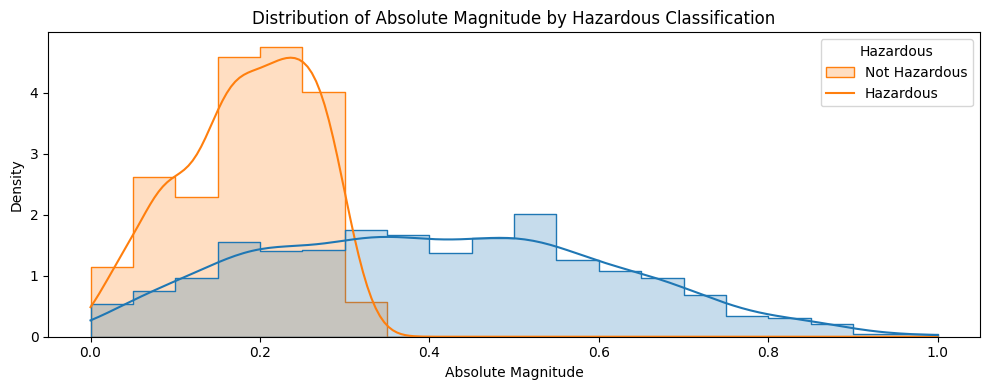

Saved: plots/scatter_Absolute Magnitude_vs_Name_20250415_154806.png


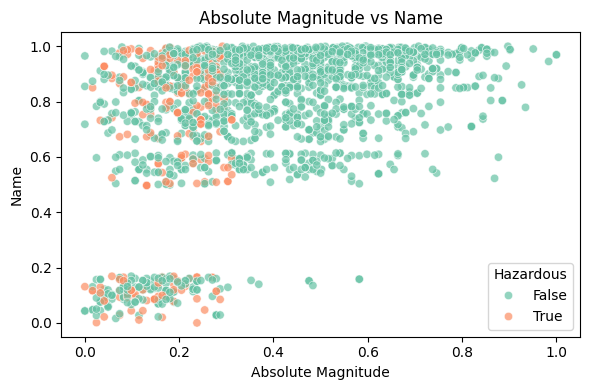

Saved: plots/scatter_Absolute Magnitude_vs_Est Dia in Feet(max)_20250415_154806.png


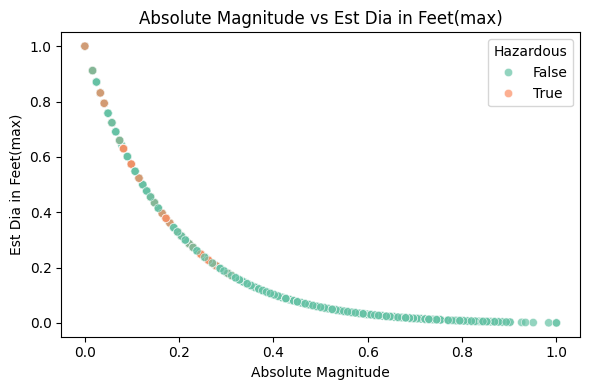

Saved: plots/scatter_Absolute Magnitude_vs_Miles per hour_20250415_154807.png


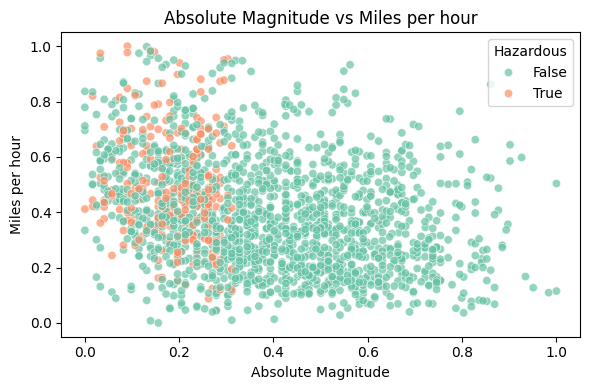

Saved: plots/distplot_Est Dia in Feet(max)_20250415_154808.png


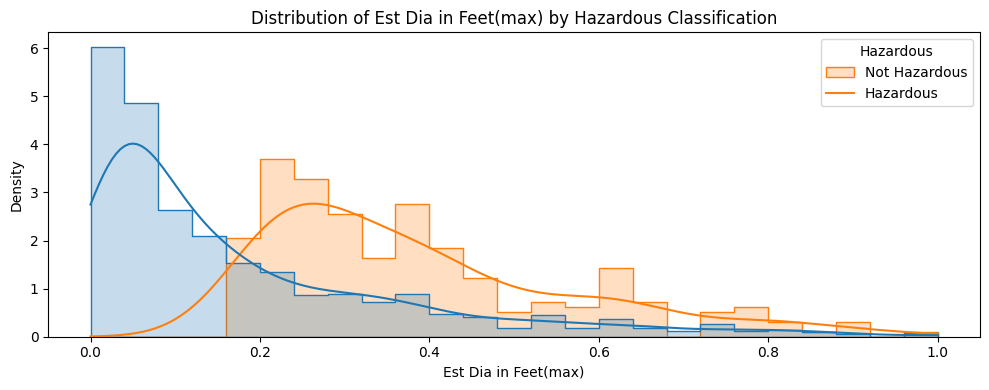

Saved: plots/scatter_Est Dia in Feet(max)_vs_Name_20250415_154809.png


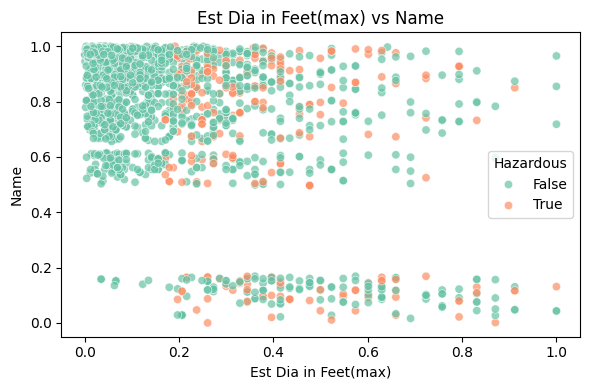

Saved: plots/scatter_Est Dia in Feet(max)_vs_Absolute Magnitude_20250415_154809.png


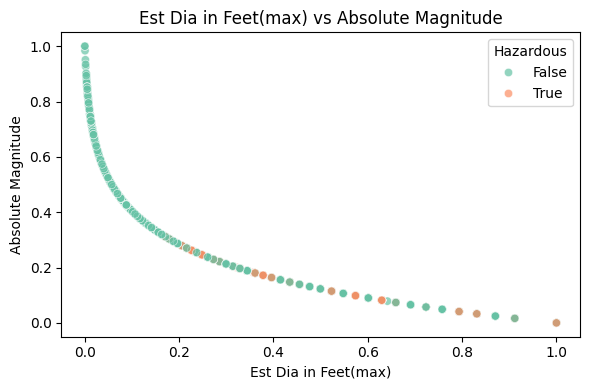

Saved: plots/scatter_Est Dia in Feet(max)_vs_Miles per hour_20250415_154810.png


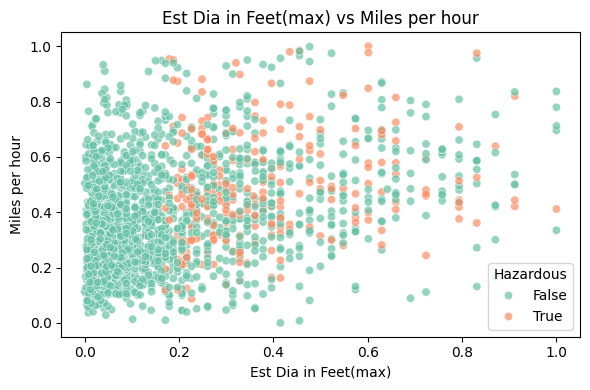

Saved: plots/distplot_Miles per hour_20250415_154811.png


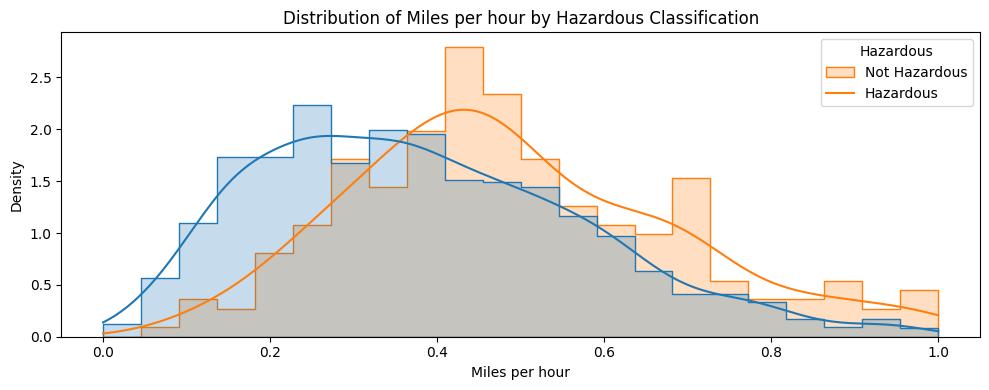

Saved: plots/scatter_Miles per hour_vs_Name_20250415_154812.png


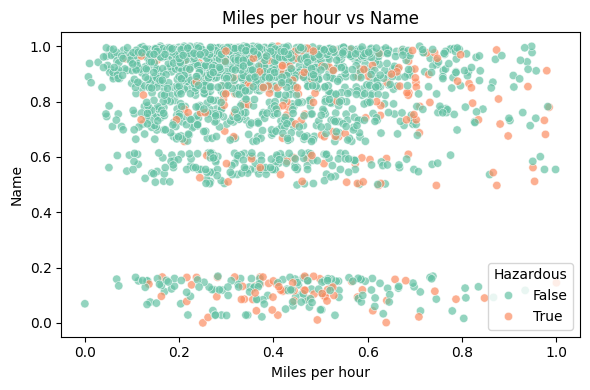

Saved: plots/scatter_Miles per hour_vs_Absolute Magnitude_20250415_154813.png


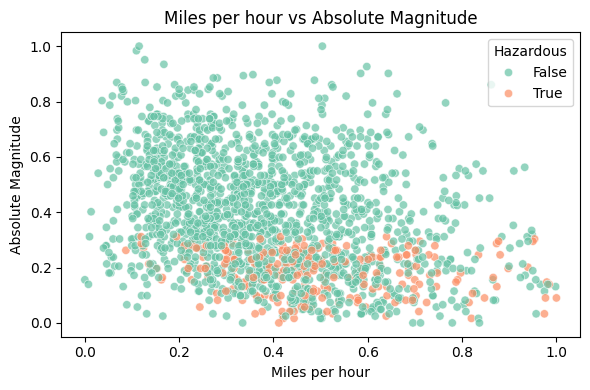

Saved: plots/scatter_Miles per hour_vs_Est Dia in Feet(max)_20250415_154814.png


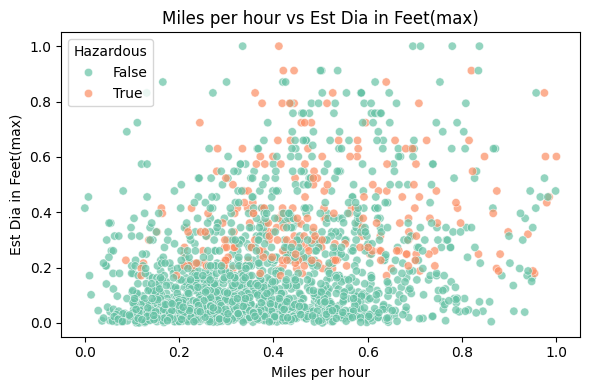

Saved: plots/correlation_heatmap_20250415_154815.png


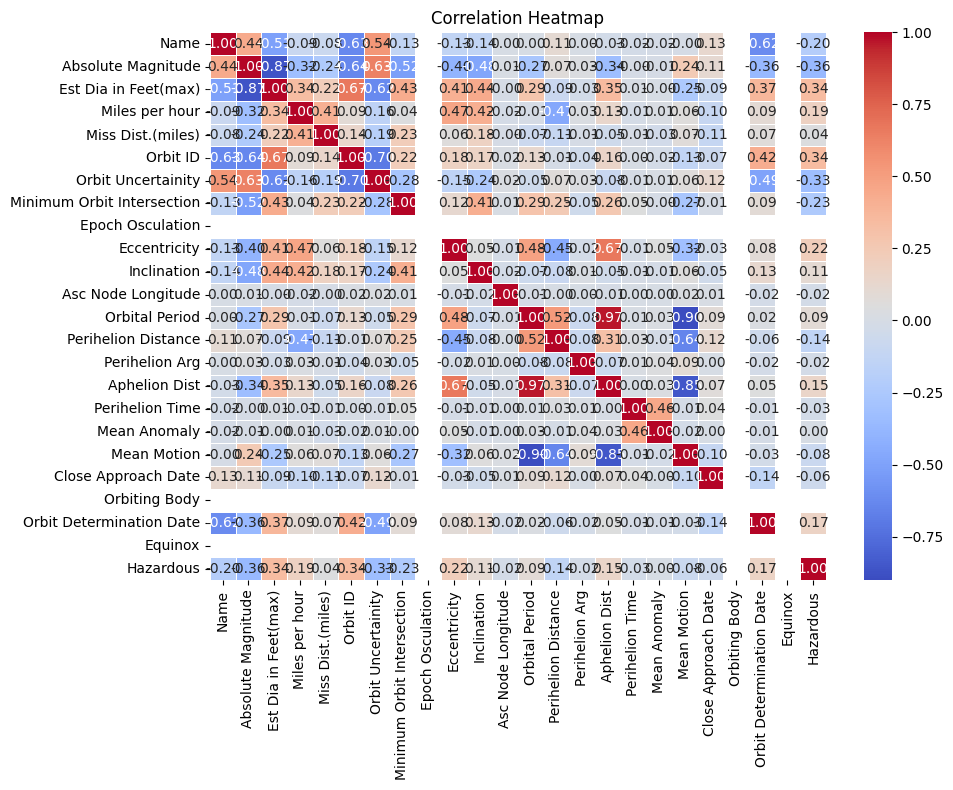

Saved: plots/barplot_actual_vs_predicted_20250415_154818.png


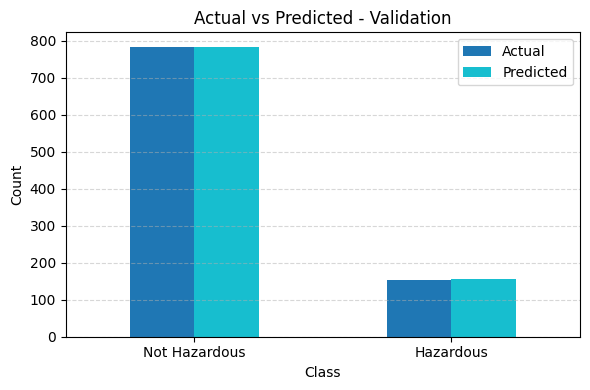

Saved: plots/barplot_actual_vs_predicted_20250415_154818.png


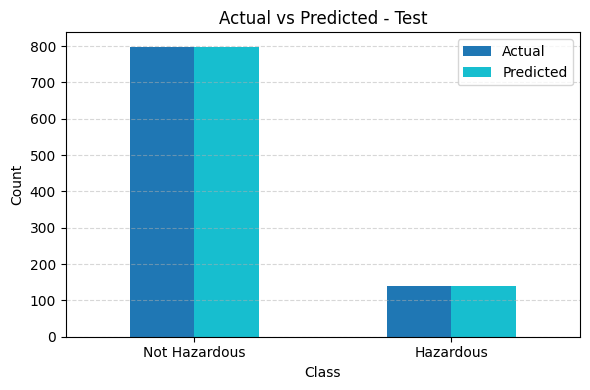

Saved: plots/lineplot_actual_vs_predicted_20250415_154819.png


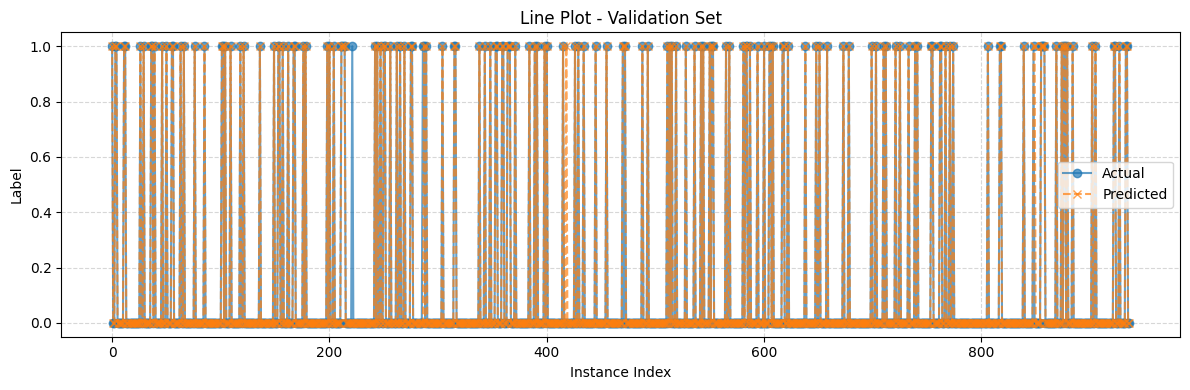

Saved: plots/lineplot_actual_vs_predicted_20250415_154820.png


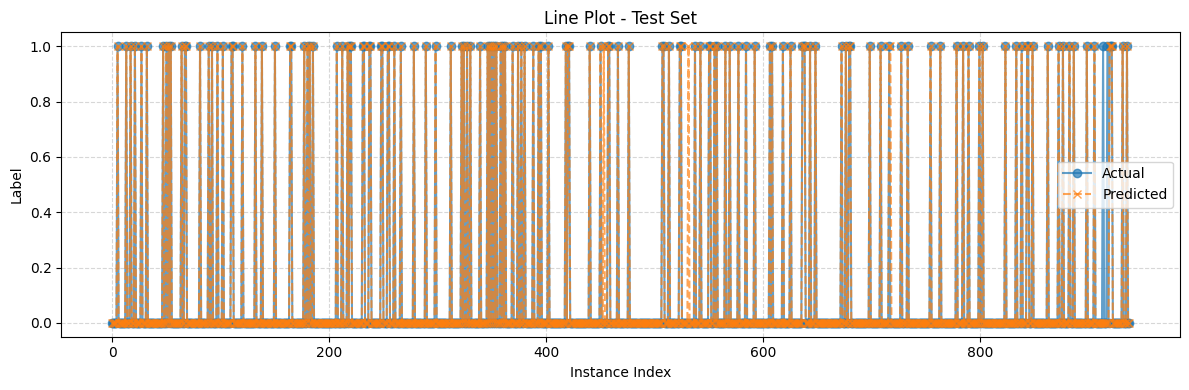


Evaluation Metrics for Random Forest Best Model Validation:


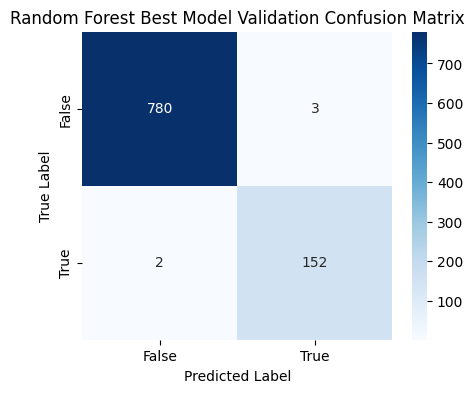


  Accuracy:  0.9947
  Precision: 0.9947
  Recall:    0.9947
  F1-score:  0.9947
Saved: plots/metrics_lineplot_Random_Forest_Best_Model_(Validation)_20250415_154821.png


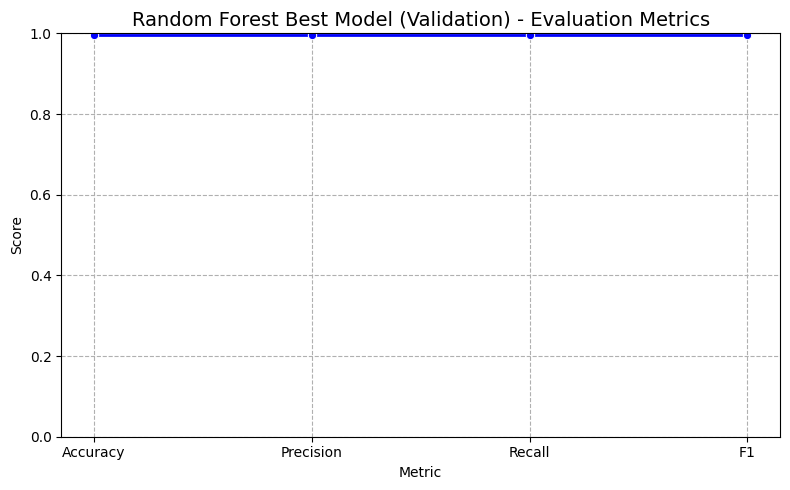

All plots saved successfully.



In [32]:
generate_all_plots(
    model=random_forest,
    X_test=X_test,
    y_test=y_test_rf,
    y_valid=y_valid_rf,
    y_pred_valid=y_valid_pred_rf,
    y_test_pred=y_test_pred_rf,
    df_train=df_train,
    model_name="Random Forest Best Model"
)